In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *



In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

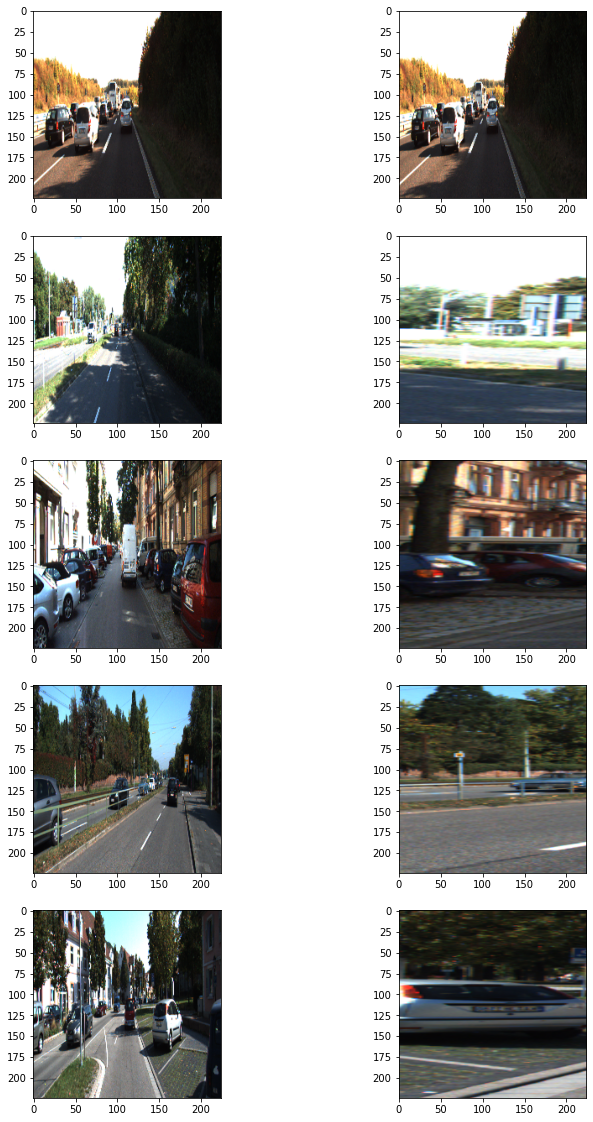

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [8]:
# IoU implementation
def iou_coef(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

def iou_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

# Visualize training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## U-Net을 구현

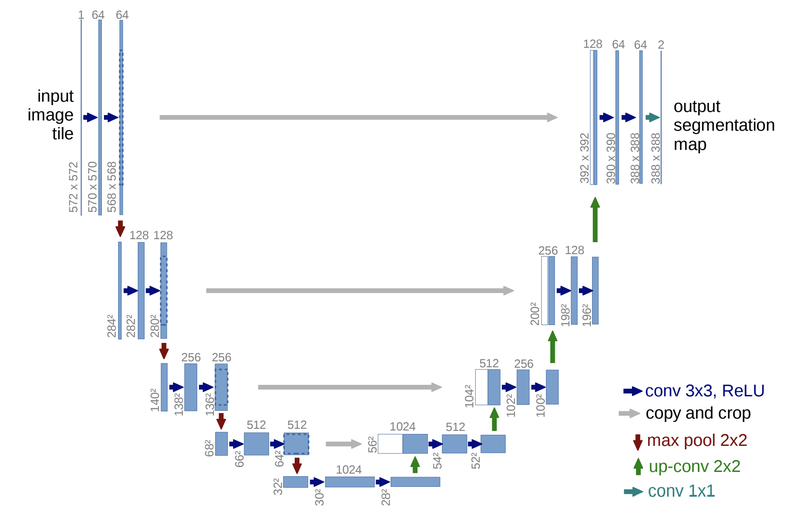

In [6]:
# Step 2: Implement U-Net model
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.2)(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.2)(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Binary segmentation for road

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint


# Save the best model and load for further training
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

# Build U-Net model
model = build_unet()

# Compile model without metrics
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[checkpoint],  # 체크포인트 콜백 추가
    verbose=1
)


# Save history as a file
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)



Epoch 1/100
11/11 [==============================] - 8s 632ms/step - loss: 0.6882 - val_loss: 0.6793

Epoch 00001: val_loss improved from inf to 0.67935, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet.h5
Epoch 2/100
11/11 [==============================] - 7s 609ms/step - loss: 0.6462 - val_loss: 0.4934

Epoch 00002: val_loss improved from 0.67935 to 0.49337, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet.h5
Epoch 3/100
11/11 [==============================] - 7s 600ms/step - loss: 0.2666 - val_loss: 0.2819

Epoch 00003: val_loss improved from 0.49337 to 0.28192, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet.h5
Epoch 4/100
11/11 [==============================] - 7s 584ms/step - loss: 0.1953 - val_loss: 0.2819

Epoch 00004: val_loss did not improve from 0.28192
Epoch 5/100
11/11 [==============================] - 6s 587ms/step - loss: 0.2795 - val_loss: 0.2819

Epoch 00005: val_loss did not improve from 0.28192
Epoch 6/100

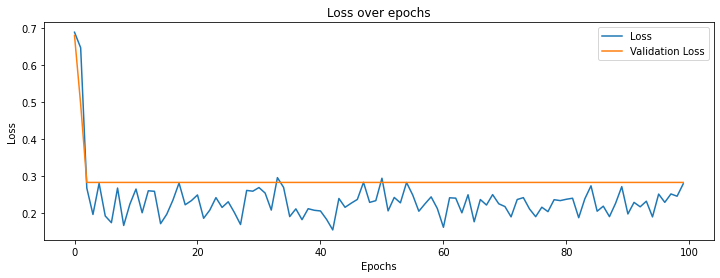

In [17]:
# Plot training history
plot_history(history)


In [18]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [19]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

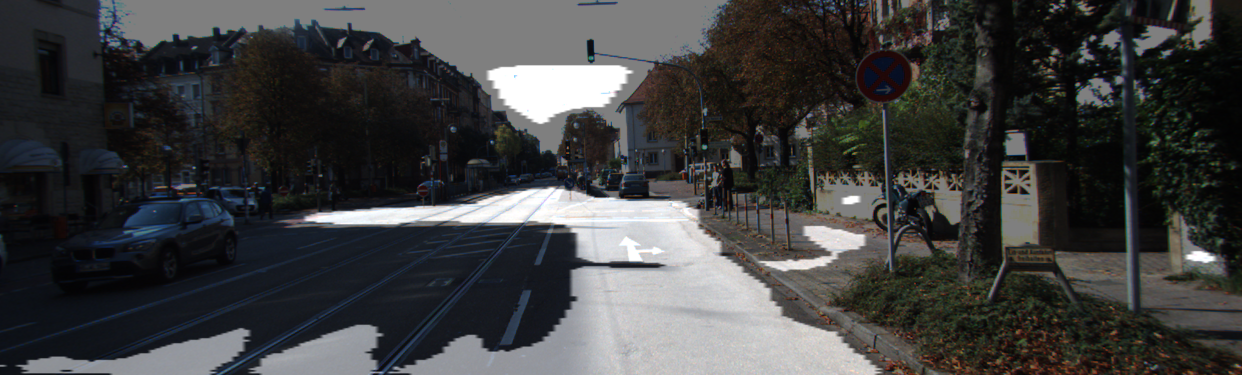

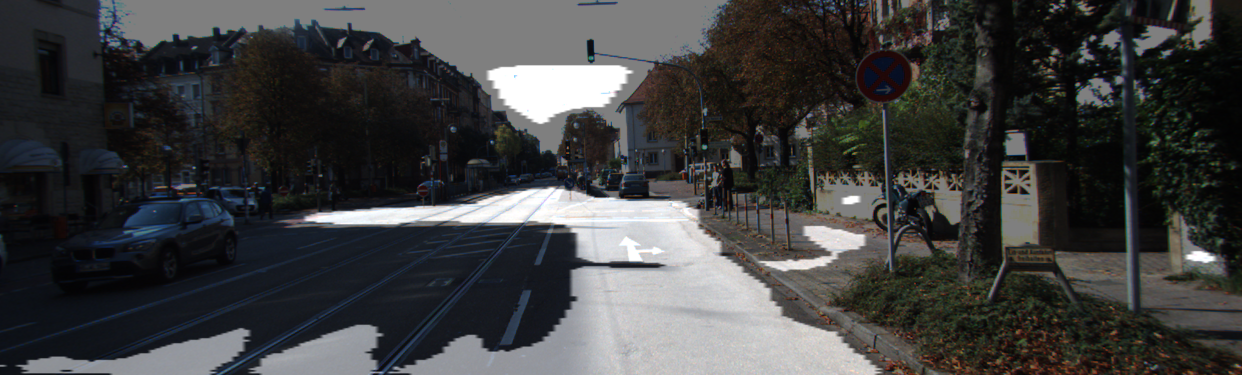

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [21]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [22]:
# IoU Calculation
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = float(intersection) / float(union) if union != 0 else 0.0
    print('IoU : %f' % iou_score)
    return iou_score


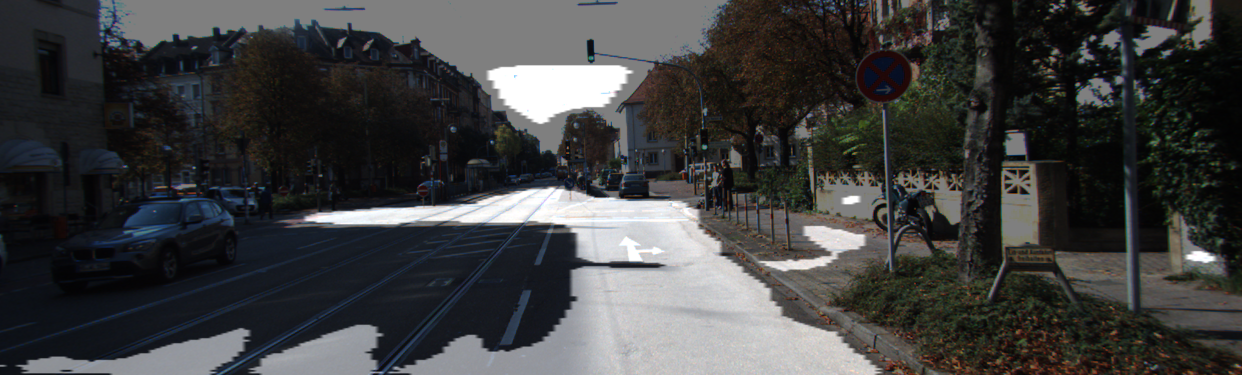

IoU : 0.419641


0.41964089410040306

In [23]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

Unet++

In [26]:
# Dice 계수 계산 함수
# Dice 계수는 교집합과 합집합을 사용하여 두 데이터 간의 유사도를 측정합니다.
# 수정된 Dice 계수 계산 함수
def dice_coef(y_true, y_pred, smooth=1e-6):
    # y_true와 y_pred의 차원 확인 후 4차원으로 확장
    y_true = tf.expand_dims(y_true, axis=-1) if tf.rank(y_true) == 3 else y_true
    y_pred = tf.expand_dims(y_pred, axis=-1) if tf.rank(y_pred) == 3 else y_pred

    # 교집합 및 합집합 계산
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])

    # Dice 계수 계산
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

# Dice 손실 함수 수정
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [27]:
# Step 2: U-Net++ 모델 구현
# U-Net++ 모델을 정의합니다.
def build_unetpp(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)  # 입력 레이어 정의

    def conv_block(inputs, filters):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)  # 첫 번째 컨볼루션
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)  # 두 번째 컨볼루션
        return x

    def nested_block(filters, *layers):
        combined = concatenate(layers, axis=-1)  # 여러 레이어 결합
        return conv_block(combined, filters)  # 결합된 레이어로 컨볼루션 수행

    def up_block(inputs, filters):
        return Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)  # 업샘플링

    # Nested U-Net++ 구조 정의
    x00 = conv_block(inputs, 64)
    p0 = MaxPooling2D((2, 2))(x00)

    x10 = conv_block(p0, 128)
    p1 = MaxPooling2D((2, 2))(x10)

    x20 = conv_block(p1, 256)
    p2 = MaxPooling2D((2, 2))(x20)

    x30 = conv_block(p2, 512)
    p3 = MaxPooling2D((2, 2))(x30)

    x40 = conv_block(p3, 1024)

    # Nested pathway 생성
    x01 = nested_block(64, x00, up_block(x10, 64))
    x11 = nested_block(128, x10, up_block(x20, 128))
    x21 = nested_block(256, x20, up_block(x30, 256))
    x31 = nested_block(512, x30, up_block(x40, 512))

    x02 = nested_block(64, x00, x01, up_block(x11, 64))
    x12 = nested_block(128, x10, x11, up_block(x21, 128))
    x22 = nested_block(256, x20, x21, up_block(x31, 256))

    x03 = nested_block(64, x00, x01, x02, up_block(x12, 64))

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x03)  # 출력 레이어 정의

    model = Model(inputs, outputs)
    return model




Epoch 1/100
11/11 [==============================] - 17s 948ms/step - loss: 0.9799 - val_loss: 0.9762
Model improved and saved at /aiffel/aiffel/semantic_segmentation/seg_model_unetpp.h5 with val_loss: 0.9762492179870605
Epoch 2/100
11/11 [==============================] - 10s 932ms/step - loss: 0.9758 - val_loss: 0.9735
Model improved and saved at /aiffel/aiffel/semantic_segmentation/seg_model_unetpp.h5 with val_loss: 0.9735276699066162
Epoch 3/100
11/11 [==============================] - 10s 942ms/step - loss: 0.9699 - val_loss: 0.9717
Model improved and saved at /aiffel/aiffel/semantic_segmentation/seg_model_unetpp.h5 with val_loss: 0.9716689586639404
Epoch 4/100
11/11 [==============================] - 10s 953ms/step - loss: 0.9827 - val_loss: 0.9716
Model improved and saved at /aiffel/aiffel/semantic_segmentation/seg_model_unetpp.h5 with val_loss: 0.9716253876686096
Epoch 5/100
11/11 [==============================] - 11s 958ms/step - loss: 0.9750 - val_loss: 0.9724
Epoch 6/100
11

In [33]:
model = build_unetpp()

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 224, 224, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_119[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_120[0][0]                 
____________________________________________________________________________________________

In [ ]:



    # 학습 기록 병합
    history_data['loss'].extend(history.history['loss'])
    history_data['val_loss'].extend(history.history['val_loss'])

    # 최적 모델 저장
    current_val_loss = history.history['val_loss'][-1]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        model.save(model_path)
        print(f"Model improved and saved at {model_path} with val_loss: {best_val_loss}")

# 학습 기록 저장
with open('training_history_unetpp.pkl', 'wb') as f:
    pickle.dump(history_data, f)
print("Training history saved as 'training_history_unetpp.pkl'")

In [29]:

# 학습 기록 시각화
plot_history(training_history_unetpp.pkl)

NameError: name 'training_history_unetpp' is not defined

In [30]:
# Dice 계수 계산 함수
# 예측값과 실제값의 Dice 계수를 계산합니다.
def calculate_dice_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()  # 교집합 계산
    union = target.sum() + prediction.sum()  # 합집합 계산
    dice_score = (2. * intersection) / union if union != 0 else 0.0  # Dice 계수 계산
    print('Dice Score : %f' % dice_score)
    return dice_score


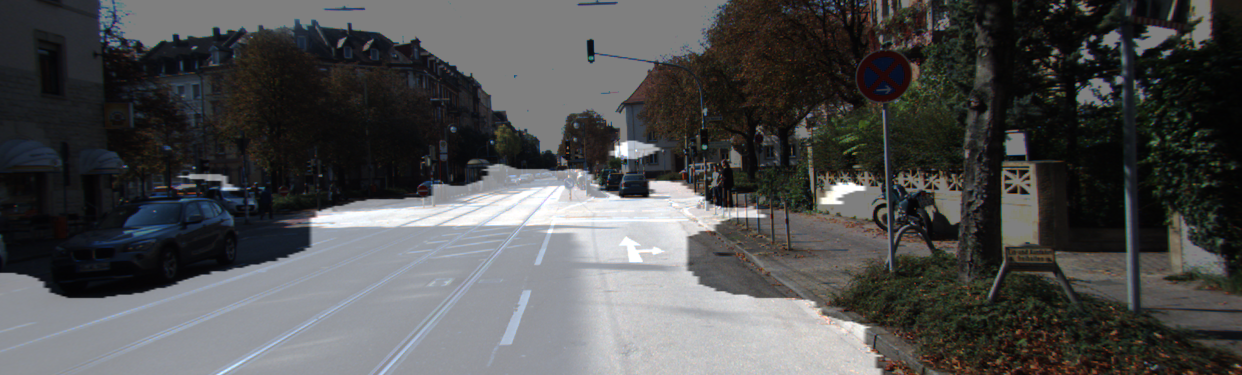

Dice Score : 0.925480


0.9254802950806738

In [31]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_dice_score(target, prediction)